# Test Retinaface
* parse through RetinaFace to understand what its doing

In [1]:
%%bash
conda info | grep "active environment"

     active environment : abh1


In [2]:
import sys
import os
import os.path as osp
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torchvision
torch.__version__

'1.6.0.dev20200605'

In [3]:
_retinapath = osp.abspath("..")
if _retinapath not in sys.path:
    sys.path.append(_retinapath)

from models.retinaface import RetinaFace
from data.config import *
from runutils import *
from layers.functions.prior_box import PriorBox
from utils.box_utils import decode, decode_landm

In [4]:
_wpath = osp.abspath("../weights")
weights = {"resnet50":osp.join(_wpath,"Resnet50_Final.pth"),
            "mobilenet0.25":osp.join(_wpath, "mobilenet0.25_Final.pth")}
for _w in weights.values():
    assert osp.isfile(_w), "%s not found"%_w
    
configs = {"resnet50":cfg_re50, "mobilenet0.25":cfg_mnet}
print(configs)
print(weights)

{'resnet50': {'name': 'Resnet50', 'min_sizes': [[16, 32], [64, 128], [256, 512]], 'steps': [8, 16, 32], 'variance': [0.1, 0.2], 'clip': False, 'loc_weight': 2.0, 'gpu_train': True, 'batch_size': 24, 'ngpu': 4, 'epoch': 100, 'decay1': 70, 'decay2': 90, 'image_size': 840, 'pretrain': True, 'return_layers': {'layer2': 1, 'layer3': 2, 'layer4': 3}, 'in_channel': 256, 'out_channel': 256}, 'mobilenet0.25': {'name': 'mobilenet0.25', 'min_sizes': [[16, 32], [64, 128], [256, 512]], 'steps': [8, 16, 32], 'variance': [0.1, 0.2], 'clip': False, 'loc_weight': 2.0, 'gpu_train': True, 'batch_size': 32, 'ngpu': 1, 'epoch': 250, 'decay1': 190, 'decay2': 220, 'image_size': 640, 'pretrain': True, 'return_layers': {'stage1': 1, 'stage2': 2, 'stage3': 3}, 'in_channel': 32, 'out_channel': 64}}
{'resnet50': '/home/z/work/gits/Face/RetinaFace/Pytorch_Retinaface/weights/Resnet50_Final.pth', 'mobilenet0.25': '/home/z/work/gits/Face/RetinaFace/Pytorch_Retinaface/weights/mobilenet0.25_Final.pth'}


### test setup

In [5]:
_net = "resnet50" #"mobilenet0.25"
device = "cuda"
cudnn.benchmark = True

In [15]:
def showboxes(image, bboxes, landms=None, max_boxes=5000, max_break=None, show=False):
    _mod = len(bboxes)//max_boxes + 1
    
    if max_break is not None:
        _mod = 1

    if show:
        plt.figure(figsize=(15, 15))
    plt.imshow(Image.open(image))
    cmap = plt.cm.get_cmap("hsv", len(bboxes))
    _j = 0
    for _i, _b in enumerate(bboxes):
        if max_break is not None and _i >= max_break:
            break
        if _j >= max_boxes:
            break 

        if not _i%_mod:
            _h = _b[2] - _b[0]
            _w = _b[3] - _b[1]
            _p = plt.Rectangle((_b[0], _b[1]), _h, _w, fill=False,
                               color=cmap(np.random.randint(0, len(bboxes))))
            plt.gca().add_patch(_p)
            if landms is not None and len(landms) > 0:
                scatter(landms[_i])
            _j+=1
    if show:
        plt.show()

def scatter(landms):
    _landms = landms.reshape(5,2).T
    plt.scatter(_landms[0], _landms[1])

In [26]:
imname = '/home/z/work/gits/Face/Face_Detection_Alignment/image/725392d3eac55aba65c2c3d24c29c2b7.jpg'

In [11]:

_printtensor = lambda x, xname: print(xname, "\t", x.dtype, x.device, " grad", x.requires_grad,
                                      " contiguous", x.is_contiguous(), "", x.shape,
                                      round(x.min().item(),3), round(x.max().item(),3))
_printarray = lambda x, xname: print(xname, "\t", x.dtype, "\t", x.shape, "\tcontiguous",
                                    x.flags['C_CONTIGUOUS'])

def detect(imname, weights, config, device="cuda", resize=1, threshold=0.02, nms_threshold=0.4,
           topk=5000, debug=True, showpriors=False):
    
    img = open_tensor(imname, dtype="float32", device="cuda", normed=False,
                      center=(104, 117, 123), backend=None, debug=False)
    _w = img.shape[3]
    _h = img.shape[2]
    scale = torch.Tensor([_w, _h]).to(device=device).div_(resize)
    if debug:
        _printtensor(scale, "scale")
        _printtensor(img, "img")

    with torch.no_grad():
        net = RetinaFace(cfg=config, phase='test')
        net = load_model(net, pretrained_path=weights, device=device).eval().to(device)
        
        loc, conf, landms = net(img)
        priorbox = PriorBox(cfg=config, image_size=(_h, _w))
        priors = priorbox.forward().to(device=device)
      
        scores = conf.clone().detach().squeeze(0)[:, 1].contiguous()

        boxes = decode(loc.squeeze(0), priors, config["variance"])
        landms = decode_landm(landms.squeeze(0), priors, config['variance'])
        
        if debug:
            _printtensor(loc, "loc")
            _printtensor(conf, "conf")
            _printtensor(landms, "landms")
            print("Priorbox\n", priorbox.__dict__)
            _printtensor(priors, "\npriors")
            _printtensor(boxes, "boxes")
            _printtensor(scores, "scores")
            _printtensor(landms, "landms")
        
        # rescale shape
        _shape = boxes.shape
        boxes.view(_shape[0], -1, 2).mul_(scale).view(*_shape)
        _shape = landms.shape
        landms.view(_shape[0], -1, 2).mul_(scale).view(*_shape)
        
        if debug:
            _printtensor(boxes, "_boxes")
            _printtensor(landms, "_landm")

        if showpriors:
            plt.figure(figsize=(20,20))
            plt.subplot(1,3,1)
            max_boxes=100
            plt.title("sample of %d from %d boxes"%(max_boxes, len(boxes)))
            showboxes(imname, boxes, max_boxes=max_boxes, show=False)#max_break=100)

        # ignore low scores
        inds = torch.where(scores > threshold)[0]
        boxes = boxes[inds]
        landms = landms[inds]
        scores = scores[inds]
        # argsort
        order = scores.argsort(descending=True)
        boxes = boxes[order]
        landms = landms[order]
        scores = scores[order]
        
        if debug:
            _printtensor(landms, "_landm")
            _printtensor(scores, "scores")
            _printtensor(boxes, "boxes")
        
        if showpriors:
            plt.subplot(1,3,2)
            plt.title("threshold > %.3f, %d detections"%(threshold, len(boxes)))
            showboxes(imname, boxes, show=False)
        
        # non maximum suppresion
        keep = torchvision.ops.nms(boxes, scores, nms_threshold)
        boxes = boxes[keep,:]
        landms = landms[keep,:]
        
        if debug:
            _printtensor(keep, "nms:keep")
            _printtensor(boxes, "nms:boxes")
            _printtensor(landms, "nms:landms")
        
        if showpriors:
            plt.subplot(1,3,3)
            plt.title("nms with threshold: %.3f, %d detections"%(nms_threshold, len(boxes)))
            showboxes(imname, boxes, landms.cpu().clone().detach().numpy(), max_boxes=50, show=False)
            plt.show()


scale 	 torch.float32 cuda:0  grad False  contiguous True  torch.Size([2]) 1920.0 2880.0
img 	 torch.float32 cuda:0  grad False  contiguous True  torch.Size([1, 3, 2880, 1920]) -123.0 109.0
loc 	 torch.float32 cuda:0  grad False  contiguous True  torch.Size([1, 226800, 4]) -5.305 5.874
conf 	 torch.float32 cuda:0  grad False  contiguous True  torch.Size([1, 226800, 2]) 0.0 1.0
landms 	 torch.float32 cuda:0  grad False  contiguous True  torch.Size([226800, 10]) -0.026 1.014
Priorbox
 {'min_sizes': [[16, 32], [64, 128], [256, 512]], 'steps': [8, 16, 32], 'clip': False, 'image_size': (2880, 1920), 'feature_maps': [[360, 240], [180, 120], [90, 60]], 'name': 's'}

priors 	 torch.float32 cuda:0  grad False  contiguous True  torch.Size([226800, 4]) 0.001 0.999
boxes 	 torch.float32 cuda:0  grad False  contiguous True  torch.Size([226800, 4]) -0.108 1.09
scores 	 torch.float32 cuda:0  grad False  contiguous True  torch.Size([226800]) 0.0 0.999
landms 	 torch.float32 cuda:0  grad False  contigu

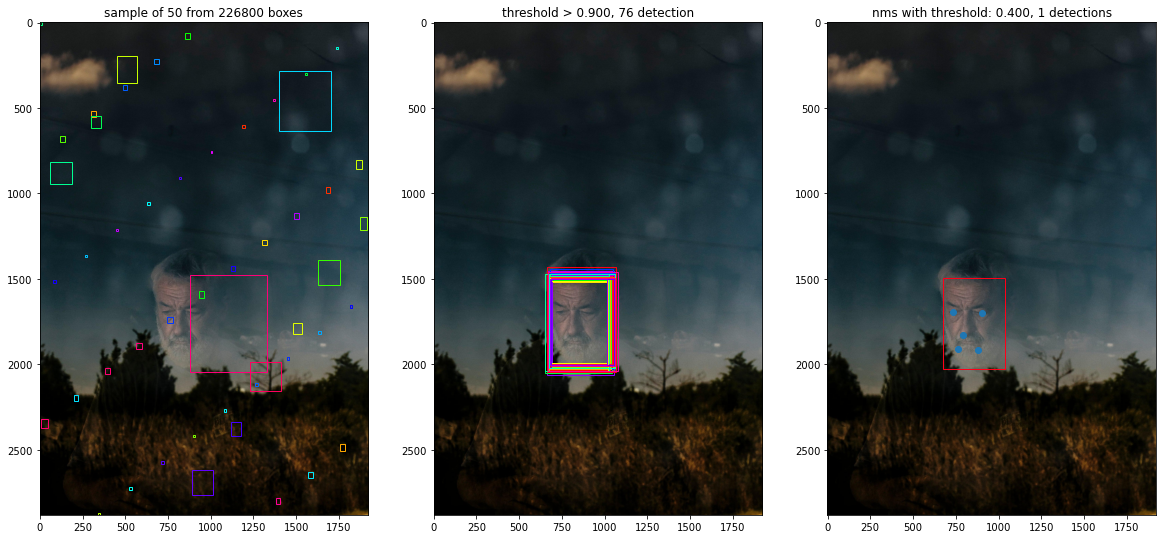

In [47]:
showpriors=True
debug=True
ff=detect(imname, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.9,
          debug=True, showpriors=showpriors)

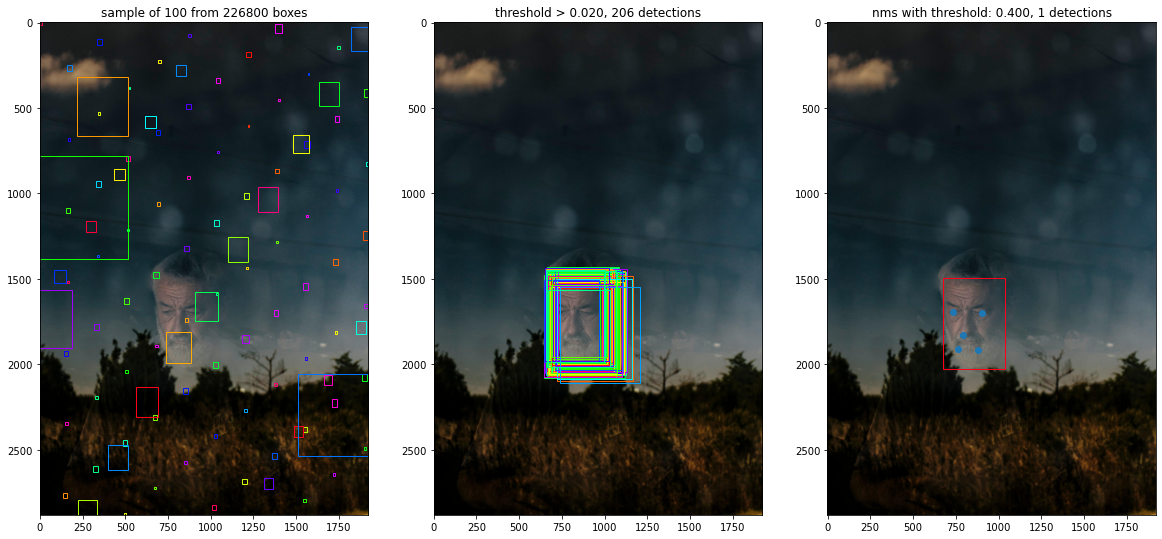

In [53]:
showpriors=True
ff=detect(imname, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.02,
          debug=False, showpriors=showpriors)

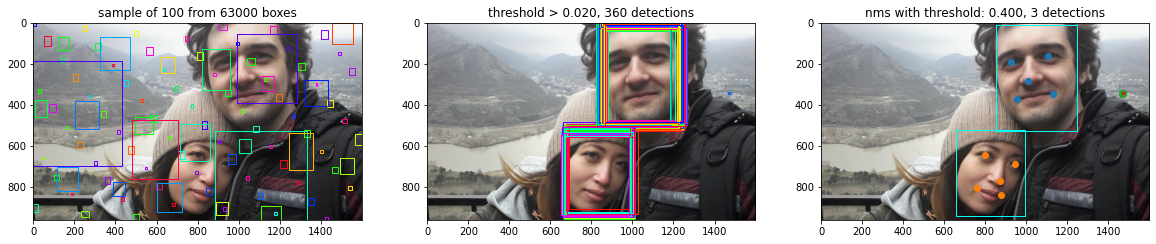

In [17]:
img = "/media/z/Malatesta/data/Self/Multitudes/how-we-met-i-took-a-good-look-at-his-photo-to-see-whether-he-might-be-sleazy_img-1.jpg"
ff=detect(img, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.02,
              debug=False, showpriors=True)

In [18]:
def get_files(folder, types=(".png", ".jpg"), force=False, val=False):
    root = osp.split(folder)[0]
    fname = folder+".txt"
    out = []
    if osp.isfile(fname) and not force:
        with open(fname, 'r') as fi:
            out = fi.read().split("\n")
        print("found", fname, "num imgs:", len(out))
        if val:
            for f in out:
                if not osp.isfile(f):
                    out = []
                    break
    if not out:
        for root, folders, files in os.walk(folder):
            out += [osp.join(root,f) for f in files if f[-4:] in types]
        with open(fname, 'w') as fi:
            fi.write("\n".join(out))
        print("collected", fname, "num imgs:", len(out))
    return out

found /media/z/Malatesta/data/Self/Multitudes.txt num imgs: 7490
/media/z/Malatesta/data/Self/Multitudes/chaos-hope-change-stories-from-70-years-of-the-peoples-republic-of-china_img-9.jpg


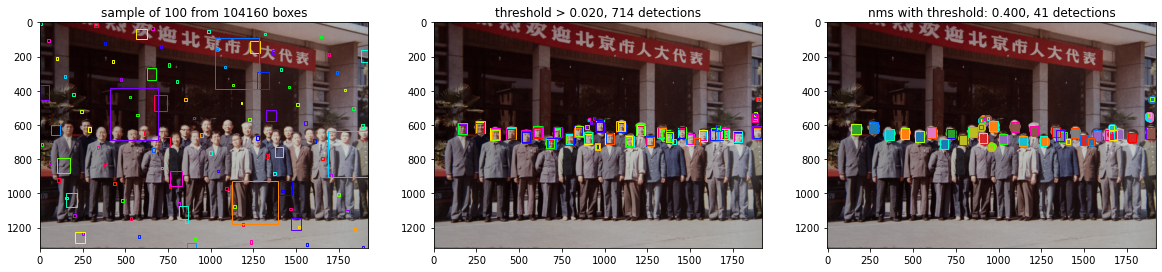

/media/z/Malatesta/data/Self/Multitudes/independence-day-fourth-july-washington-dc-parade-trump-in-pictures_img-1.jpg


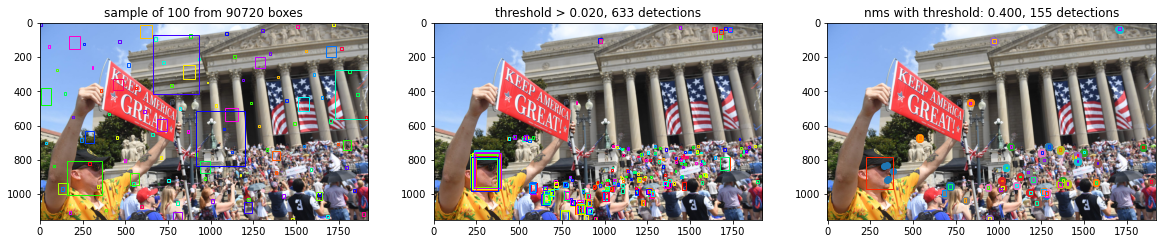

/media/z/Malatesta/data/Self/Multitudes/syrian-military-helicopter-shot-down-amid-tensions-with-turkey#img-2_syrian-military-helicopter-shot-down-amid-tensions-with-turkey_img-2.jpg


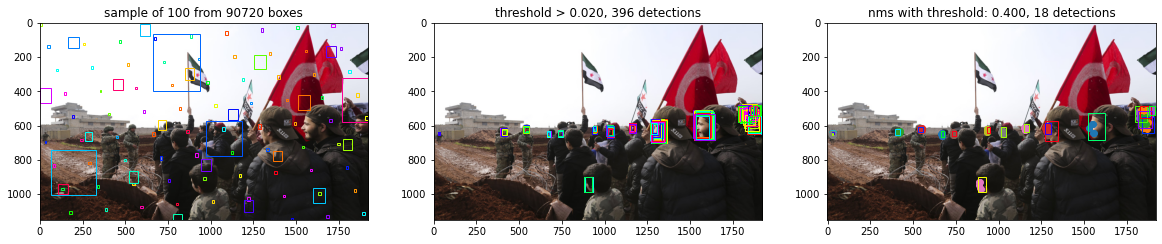

/media/z/Malatesta/data/Self/Multitudes/nurses-surgeons-janitors-first-us-health-workers-to-die-covid-19#img-1_nurses-surgeons-janitors-first-us-health-workers-to-die-covid-19_img-1.jpg


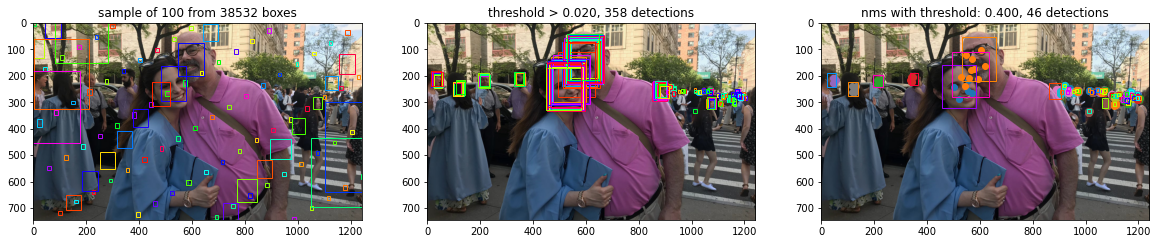

/media/z/Malatesta/data/Self/Multitudes/millions-of-pigs-culled-across-asia-african-swine-fever-spreads-thailand-#img-1_millions-of-pigs-culled-across-asia-african-swine-fever-spreads-thailand-_img-1.jpg


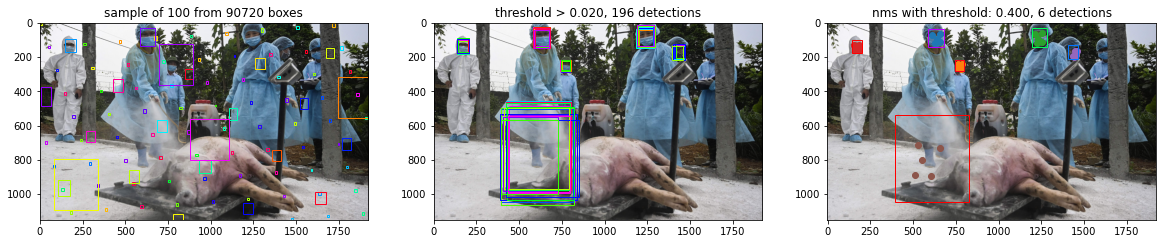

/media/z/Malatesta/data/Self/Multitudes/the-real-story-behind-the-greatest-showman-is-one-of-exploitation-its-time-we-told-it_img-4.jpg


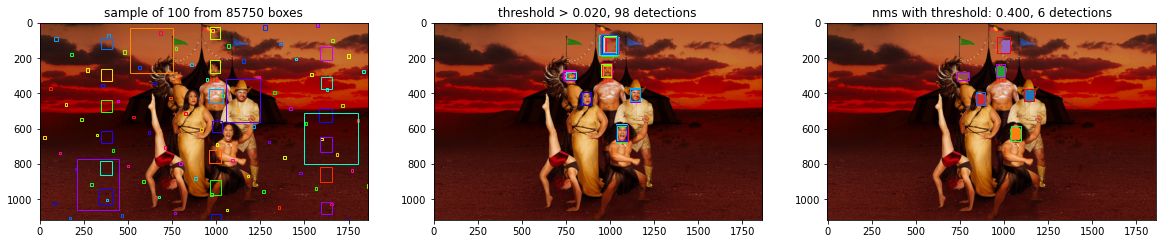

/media/z/Malatesta/data/Self/Multitudes/yoga-and-surfing-holiday-algarve-portugal_img-4.jpg


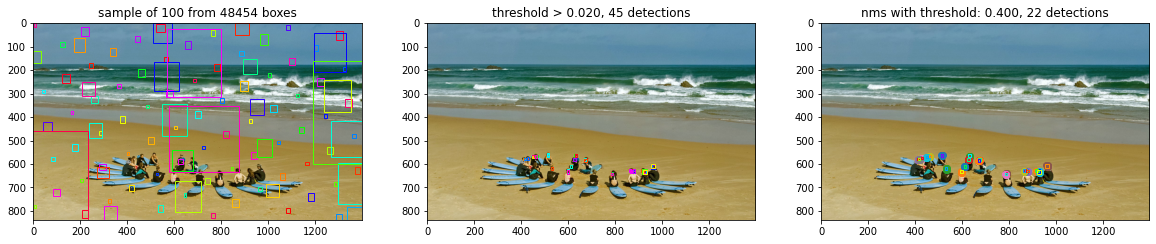

/media/z/Malatesta/data/Self/Multitudes/us-actors-british-tv-shows-rob-lowe-wild-bill_img-2.jpg


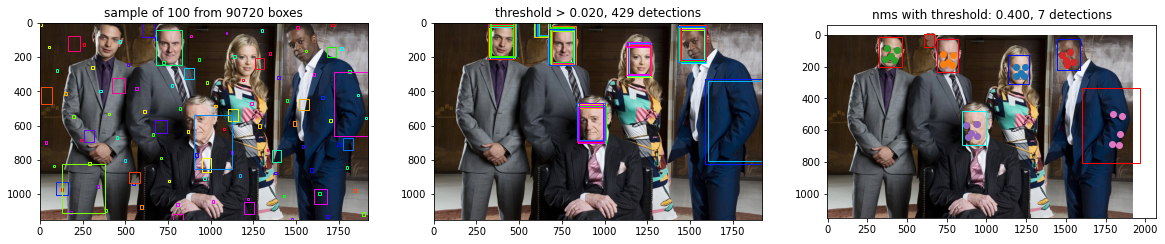

/media/z/Malatesta/data/Self/Multitudes/us-puerto-rico-protests-lin-manuel-miranda_img-1.jpg


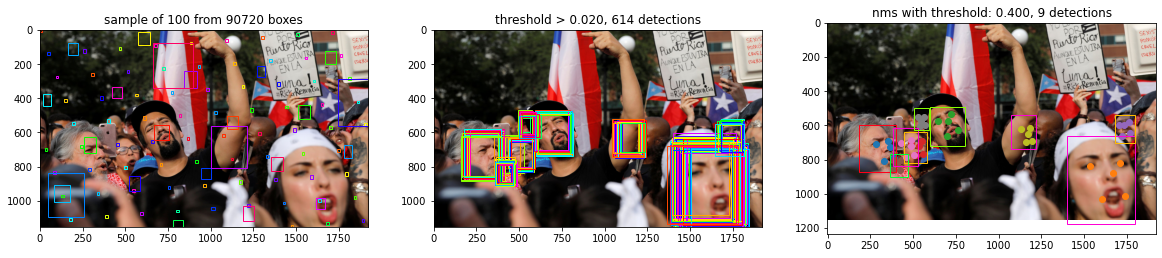

/media/z/Malatesta/data/Self/Multitudes/no-profit-no-food-lockdown-in-kabul-prompts-hunger-fears#img-3_no-profit-no-food-lockdown-in-kabul-prompts-hunger-fears_img-3.jpg


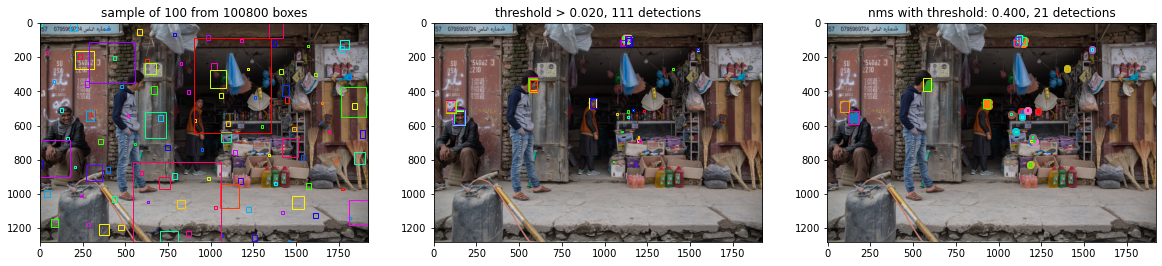

In [19]:
files = get_files("/media/z/Malatesta/data/Self/Multitudes")
for i in range(10):
    img = files[random.randint(0,len(files)-1)]
    print(img)
    showpriors=True
    ff=detect(img, weights=weights[_net], config=configs[_net], device="cuda:0", threshold=0.02,
              debug=False, showpriors=showpriors)